#Import needed modules

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


#Import Data

In [ ]:
from glob import glob
train_dir="/content/drive/Othercomputers/My Laptop/data images CWT2"
covid_19 = glob(train_dir + "/covid-19/*" )
other_corona = glob(train_dir + "/other corona viruses/*" )

print("We have total {} covid_19 Images".format(len(covid_19)))
print("We have total {} other_corona Images".format(len(other_corona)))

We have total 1030 covid_19 Images
We have total 1030 other_corona Images


#Data preprocessing

In [ ]:
#@title Balancing data
# Generate data paths with labels
data_dir = '/content/drive/Othercomputers/My Laptop/data images CWT2'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [ ]:
#@title Create image data generator
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img
tr_gen = ImageDataGenerator(preprocessing_function= scalar,rescale=1./1)
ts_gen = ImageDataGenerator(preprocessing_function= scalar,rescale=1./1)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 1648 validated image filenames belonging to 2 classes.
Found 206 validated image filenames belonging to 2 classes.
Found 206 validated image filenames belonging to 2 classes.


#Model (EfficientNet-b0)

In [ ]:
#@title model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb0 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 4,338,558
Non-t

In [ ]:
#@title Train model
batch_size = 16   # set batch size for training
epochs = 50   # number of all epochs in training
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
history2 = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/50
103/103 [==============================] - 286s 2s/step - loss: 7.2859 - accuracy: 0.6153 - val_loss: 6.4357 - val_accuracy: 0.5922
Epoch 2/50
103/103 [==============================] - 16s 158ms/step - loss: 5.2949 - accuracy: 0.7985 - val_loss: 4.9142 - val_accuracy: 0.7427
Epoch 3/50
103/103 [==============================] - 16s 159ms/step - loss: 4.1482 - accuracy: 0.8823 - val_loss: 3.8740 - val_accuracy: 0.8350
Epoch 4/50
103/103 [==============================] - 16s 158ms/step - loss: 3.2844 - accuracy: 0.9308 - val_loss: 3.1180 - val_accuracy: 0.8641
Epoch 5/50
103/103 [==============================] - 16s 158ms/step - loss: 2.6304 - accuracy: 0.9502 - val_loss: 2.5830 - val_accuracy: 0.8544
Epoch 6/50
103/103 [==============================] - 17s 161ms/step - loss: 2.1341 - accuracy: 0.9551 - val_loss: 2.0969 - val_accuracy: 0.8592
Epoch 7/50
103/103 [==============================] - 17s 160ms/step - loss: 1.7203 - accuracy: 0.9812 - val_loss: 1.7829 - val_accu

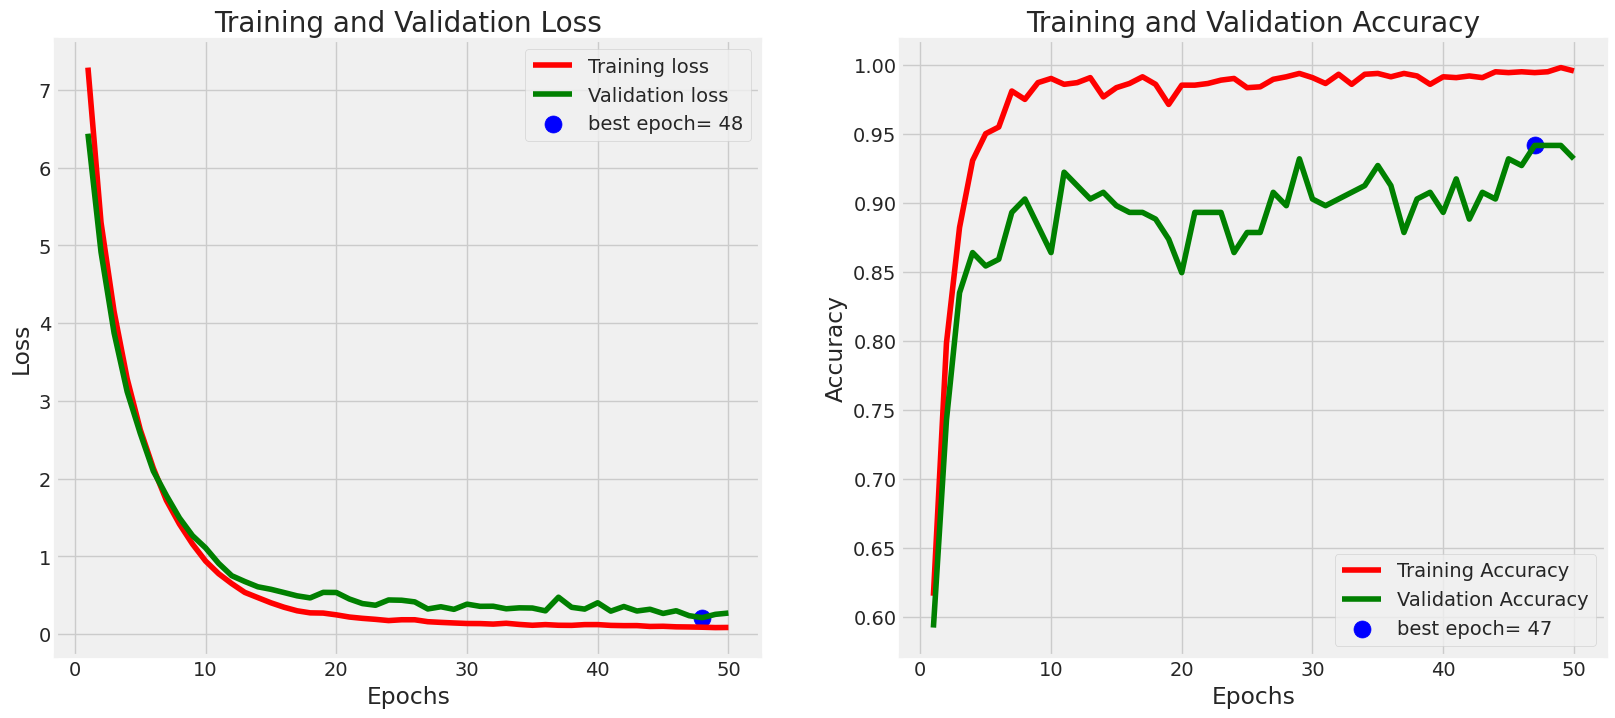

In [ ]:
#@title Display model performance
tr_acc = history2.history['accuracy']
tr_loss = history2.history['loss']
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history2
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#@title Evaluate model
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

 13/103 [==>...........................] - ETA: 7s - loss: 0.2701 - accuracy: 0.9320

103/103 [==============================] - 23s 224ms/step - loss: 0.2544 - accuracy: 0.9126
Train Loss:  0.06705214828252792
Train Accuracy:  1.0
--------------------
Validation Loss:  0.27013951539993286
Validation Accuracy:  0.9320388436317444
--------------------
Test Loss:  0.25438016653060913
Test Accuracy:  0.9126213788986206


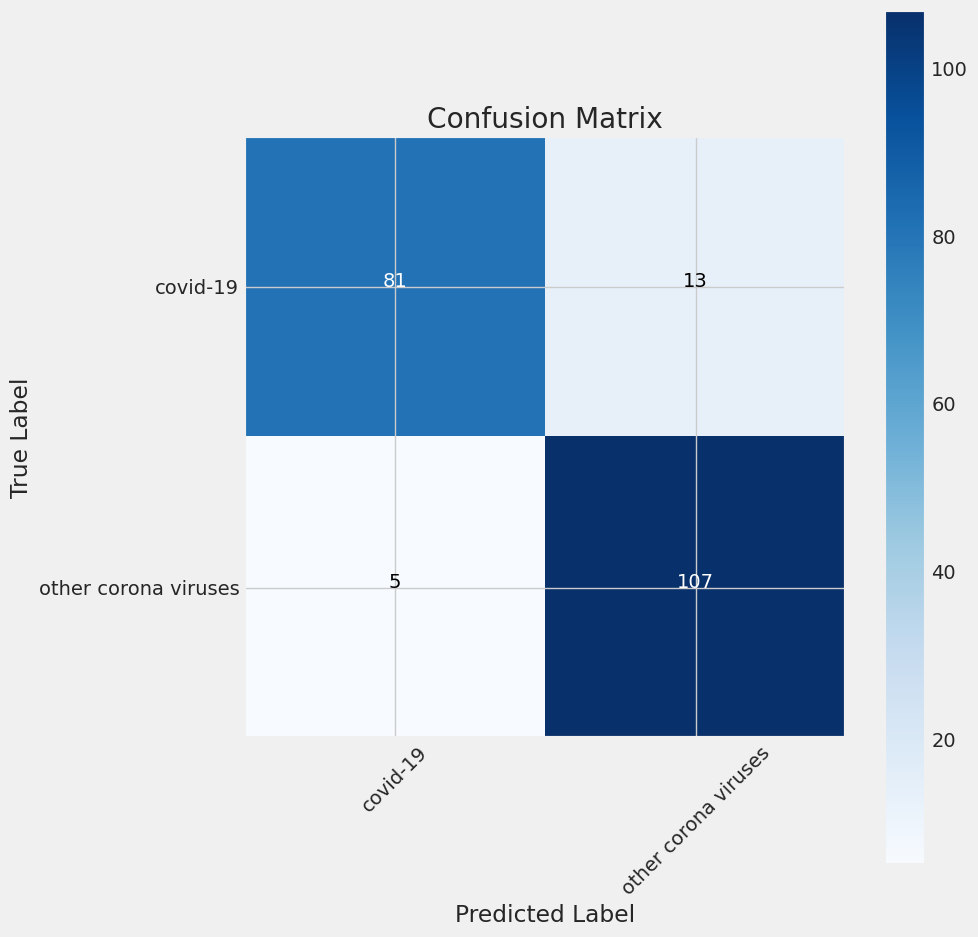

In [ ]:
#@title Confusion Matrics
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#@title classification report
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

            covid-19       0.94      0.86      0.90        94
other corona viruses       0.89      0.96      0.92       112

            accuracy                           0.91       206
           macro avg       0.92      0.91      0.91       206
        weighted avg       0.91      0.91      0.91       206



#Testing (EfficientNet-b0)

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Define the directory for the patient
patient_dir = '/content/drive/Othercomputers/My Laptop/test/other_coronaviruses'
patient_dir2= '/content/drive/Othercomputers/My Laptop/test/covid'

# Load the trained model
#model = load_model('/content/drive/MyDrive/1D Signal to 2D image/model.h5')

# Create an ImageDataGenerator object for data preprocessing
def scalar(img):
    return img

data_gen = ImageDataGenerator(preprocessing_function= scalar)

# Define the parameters for the data generator
img_size = (224, 224)
batch_size = 1

# Create a DirectoryIterator object for the patient
patient_iter = data_gen.flow_from_directory(
    patient_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
patient_iter2 = data_gen.flow_from_directory(
    patient_dir2,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 1030 images belonging to 10 classes.
Found 1030 images belonging to 10 classes.


In [ ]:
# Get the predictions for all images in the patient directory
num_images = len(patient_iter.filenames)
image_predictions = np.zeros((num_images,))
patient_predictions = np.zeros((10,))
patient_predicted_labels = np.zeros((10,))
for i in range(num_images):
    batch = patient_iter.next()
    print(i)
    preprocessed_images = batch[0]
    predictions = model.predict(preprocessed_images)
    class_predictions = np.argmax(predictions, axis=1)
    image_predictions[i] = class_predictions.mean()

    # Group the predictions for each patient
    if (i+1) % 103 == 0:
        start_idx = i - 102
        end_idx = i + 1
        patient_id = int(i/103)
        patient_predictions[patient_id] = np.argmax(np.bincount(image_predictions[start_idx:end_idx].astype(int)))
        patient_predicted_labels[patient_id] = patient_predictions[patient_id]

# Print the patient-level predictions
for patient_id in range(10):
    if patient_predictions[patient_id] == 0:
        print(f'Patient {patient_id+1} is predicted to have COVID-19.')
    else:
        print(f'Patient {patient_id+1} is predicted to have another type of coronavirus.')

0
1/1 [==============================] - 2s 2s/step
1
1/1 [==============================] - 0s 41ms/step
2
1/1 [==============================] - 0s 39ms/step
3
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 27ms/step
5
1/1 [==============================] - 0s 26ms/step
6
1/1 [==============================] - 0s 28ms/step
7
1/1 [==============================] - 0s 31ms/step
8
1/1 [==============================] - 0s 28ms/step
9
1/1 [==============================] - 0s 27ms/step
10
1/1 [==============================] - 0s 31ms/step
11
1/1 [==============================] - 0s 25ms/step
12
1/1 [==============================] - 0s 35ms/step
13
1/1 [==============================] - 0s 27ms/step
14
1/1 [==============================] - 0s 28ms/step
15
1/1 [==============================] - 0s 28ms/step
16
1/1 [==============================] - 0s 36ms/step
17
1/1 [==============================] - 0s 27ms/step
18
1/1 [==============

In [ ]:
# Get the predictions for all images in the patient directory
num_images2 = len(patient_iter2.filenames)
image_predictions2 = np.zeros((num_images2,))
patient_predictions2 = np.zeros((10,))
patient_predicted2_labels = np.zeros((10,))
for i in range(num_images2):
    batch2 = patient_iter2.next()
    print(i)
    preprocessed_images2 = batch2[0]
    predictions2 = model.predict(preprocessed_images2)
    class_predictions2 = np.argmax(predictions2, axis=1)
    image_predictions2[i] = class_predictions2.mean()

    # Group the predictions for each patient
    if (i+1) % 103 == 0:
        start_idx = i - 102
        end_idx = i + 1
        patient_id = int(i/103)
        patient_predictions2[patient_id] = np.argmax(np.bincount(image_predictions2[start_idx:end_idx].astype(int)))
        patient_predicted2_labels[patient_id] = patient_predictions2[patient_id]

# Print the patient-level predictions
for patient_id in range(10):
    if patient_predictions2[patient_id] == 0:
        print(f'Patient {patient_id+1} is predicted to have COVID-19.')
    else:
        print(f'Patient {patient_id+1} is predicted to have another type of coronavirus.')

0
1/1 [==============================] - 0s 26ms/step
1
1/1 [==============================] - 0s 29ms/step
2
1/1 [==============================] - 0s 40ms/step
3
1/1 [==============================] - 0s 49ms/step
4
1/1 [==============================] - 0s 41ms/step
5
1/1 [==============================] - 0s 43ms/step
6
1/1 [==============================] - 0s 41ms/step
7
1/1 [==============================] - 0s 46ms/step
8
1/1 [==============================] - 0s 37ms/step
9
1/1 [==============================] - 0s 44ms/step
10
1/1 [==============================] - 0s 33ms/step
11
1/1 [==============================] - 0s 26ms/step
12
1/1 [==============================] - 0s 27ms/step
13
1/1 [==============================] - 0s 27ms/step
14
1/1 [==============================] - 0s 27ms/step
15
1/1 [==============================] - 0s 25ms/step
16
1/1 [==============================] - 0s 25ms/step
17
1/1 [==============================] - 0s 25ms/step
18
1/1 [============

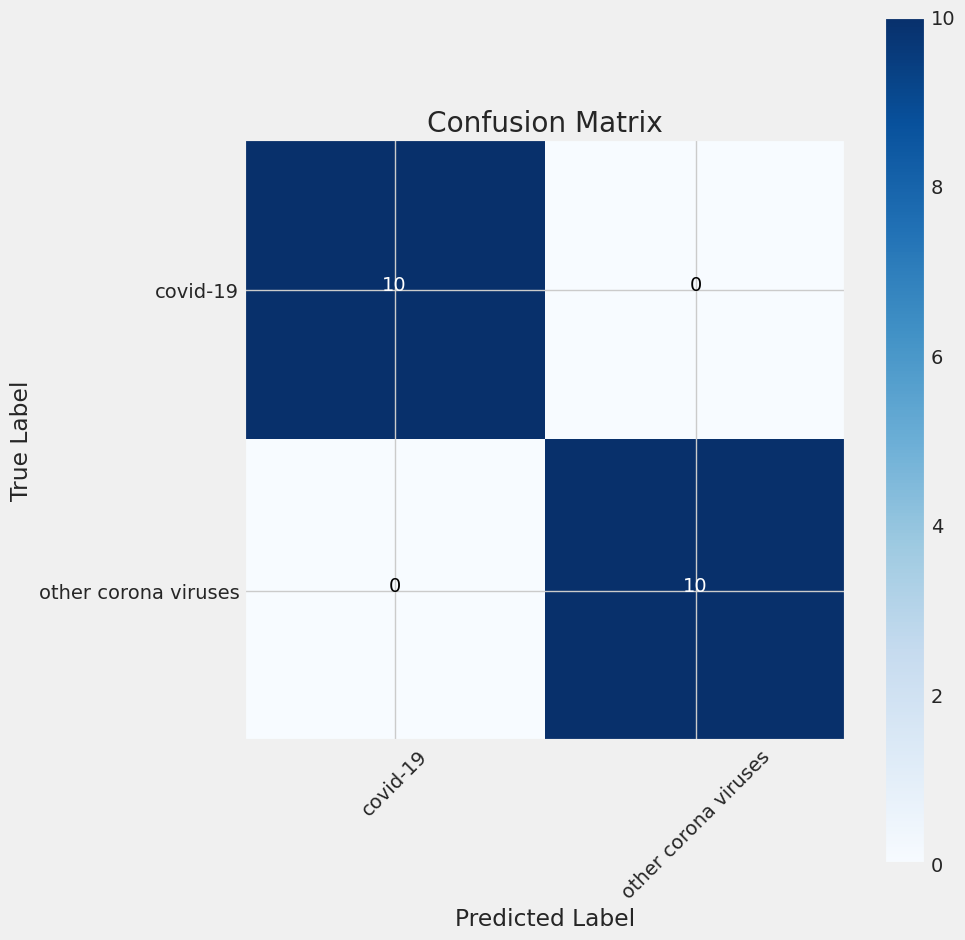

                      precision    recall  f1-score   support

            covid-19       1.00      1.00      1.00        10
other corona viruses       1.00      1.00      1.00        10

            accuracy                           1.00        20
           macro avg       1.00      1.00      1.00        20
        weighted avg       1.00      1.00      1.00        20



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
prediction_result = np.concatenate((patient_predicted2_labels, patient_predicted_labels))
zeros = np.zeros(10)
ones = np.ones(10)
actual_result = np.concatenate((zeros, ones))
# build the confusion matrix
cm = confusion_matrix(actual_result, prediction_result)
classes=["covid-19","other corona viruses"]
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()
print(classification_report(actual_result, prediction_result,target_names= classes))

In [ ]:
# Make predictions for the patient
num_images = len(patient_iter.filenames[0:103])
image_predictions = np.zeros((num_images,))
for i in range(num_images):
    batch = patient_iter.next()
    preprocessed_images = batch[0]
    predictions = model.predict(preprocessed_images)
    class_predictions = np.argmax(predictions, axis=1)
    image_predictions[i] = class_predictions.mean()

# Calculate the patient-level prediction
patient_prediction = int(np.round(image_predictions.mean()))

# Update the patient-level prediction to the major predicted state
num_covid_predictions = np.sum(image_predictions == 0)
num_other_predictions = np.sum(image_predictions == 1)
if num_covid_predictions > num_other_predictions:
    patient_prediction = 0
else:
    patient_prediction = 1

# Print the patient-level prediction
if patient_prediction == 0:
    print('The patient is predicted to have COVID-19.')
else:
    print('The patient is predicted to have another type of coronavirus.')


1/1 [==============================] - 0s 26ms/step
The patient is predicted to have another type of coronavirus.


In [ ]:
image_predictions

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1.])